# Setup

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

/var/folders/cn/qh1c0kgs1y7bqdlpqd82cpqc0000gn/T/ipykernel_52212/1536809154.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [531]:
procs_added = pd.read_csv("procs_added.txt", index_col=None, names=["tick", "machineID", "procType", "sla", "actualComp", "migrated"])
procs_current = pd.read_csv("procs_current.txt", index_col=None, names=["tick", "machineID", "coreId", "sla", "actualComp", "compDone"])
procs_done = pd.read_csv("procs_done.txt", index_col=None, names=["tick", "machineID", "procType", "sla", "ticksPassed", "actualComp", "timesReplenished"])
procs_killed = pd.read_csv("procs_killed.txt", index_col=None, names=["tick", "machineID", "sla", "compDone", "memUsed"])

# sched_decisions = pd.read_csv("sched.txt", index_col=None, names=["tick", "machineID", "sla", "compDone", "ticksPassed", "ticksGiven", "done"])


# Overall Overview

In [532]:
# prepare
procs_current["compLeft"] = procs_current["sla"] - procs_current["compDone"]
procs_added["compLeft"] = procs_added["sla"]
all_procs = pd.concat([procs_current[['tick', "compLeft"]], procs_added[["tick", "compLeft"]]])
load_num_procs_per_tick = all_procs[["tick"]].groupby("tick").size().reset_index(name='numProcsCurrent')
load_work_per_tick = all_procs.groupby("tick").sum().reset_index()

procs_done['timePassedAsPct'] = (100 * procs_done["ticksPassed"]) / procs_done["sla"]

procs_late = procs_done.where(procs_done["ticksPassed"] > procs_done["sla"]).dropna().reset_index(drop=True)
procs_late = procs_late.where(procs_late["ticksPassed"] > procs_late["actualComp"]).dropna().reset_index(drop=True)

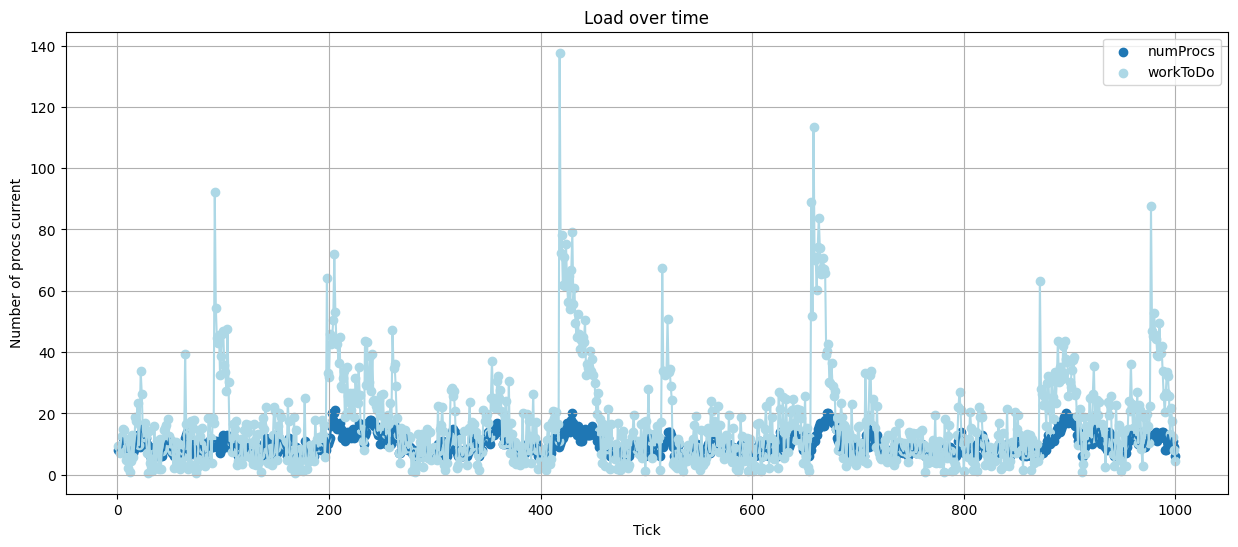

In [533]:
# load over time

# hm should load be number of procs or number of ticks?

plt.figure(figsize=(15,6))
plt.scatter(load_num_procs_per_tick["tick"], load_num_procs_per_tick["numProcsCurrent"], label="numProcs")
plt.plot(load_num_procs_per_tick["tick"], load_num_procs_per_tick["numProcsCurrent"])

plt.scatter(load_work_per_tick["tick"], load_work_per_tick["compLeft"], color='lightblue', label="workToDo")
plt.plot(load_work_per_tick["tick"], load_work_per_tick["compLeft"], color='lightblue')

plt.title('Load over time')
plt.xlabel('Tick')
plt.ylabel('Number of procs current')
# plt.xlim((550, 700)) 
plt.grid(True)
plt.legend()
plt.show()


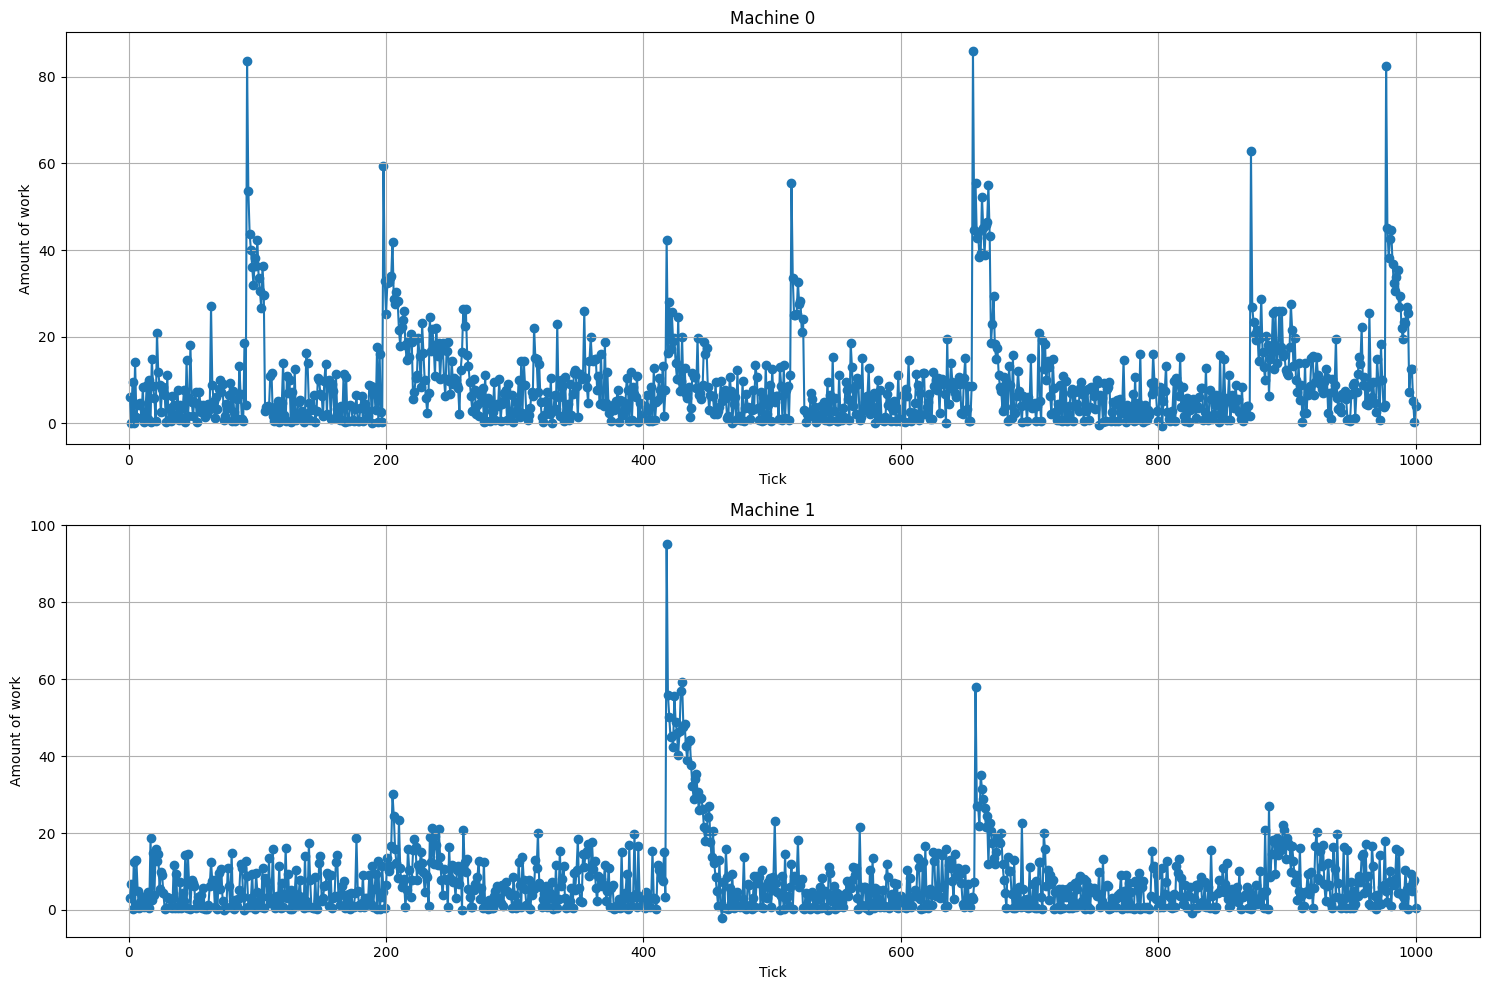

In [534]:
# load per machine over time -- this looks at ticks of work, not just proc number

# all_procs = pd.concat([procs_current[['tick', 'machineID']], procs_added[["tick", 'machineID']]])
# load_per_tick_per_machine = all_procs[["tick", "machineID"]].groupby(["tick", "machineID"]).size().reset_index(name='numProcsCurrent')

all_procs_with_comp = pd.concat([procs_current[['tick', 'machineID', "compLeft"]], procs_added[["tick", "compLeft", 'machineID']]])
load_work_per_tick_per_machine = all_procs_with_comp.groupby(["tick", "machineID"]).sum().reset_index()

unique_ids = load_work_per_tick_per_machine['machineID'].unique()

# Set up subplots
num_plots = len(unique_ids)
num_cols = 1  # Adjust as needed
num_rows = -(-num_plots // num_cols)  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
if num_rows > 1 and num_cols > 1:
    axes = axes.flatten()

# Plot each machine's data
for i, id_ in enumerate(unique_ids):
    ax = axes[i]
    # load_machine = load_per_tick_per_machine.where((load_per_tick_per_machine['machineID']==id_)).dropna().reset_index(drop=True)
    work_machine = load_work_per_tick_per_machine.where((load_work_per_tick_per_machine['machineID']==id_)).dropna().reset_index(drop=True)

    # Plotting
    # ax.scatter(load_machine["tick"], load_machine["numProcsCurrent"])
    # ax.plot(load_machine["tick"], load_machine["numProcsCurrent"])
    ax.scatter(work_machine["tick"], work_machine["compLeft"])
    ax.plot(work_machine["tick"], work_machine["compLeft"])

    ax.set_title(f'Machine {id_}')
    ax.set_xlabel('Tick')
    ax.set_ylabel('Amount of work')
    ax.grid(True)

# If there are unused subplots, hide them
for i in range(len(unique_ids), num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

<Figure size 1500x600 with 0 Axes>

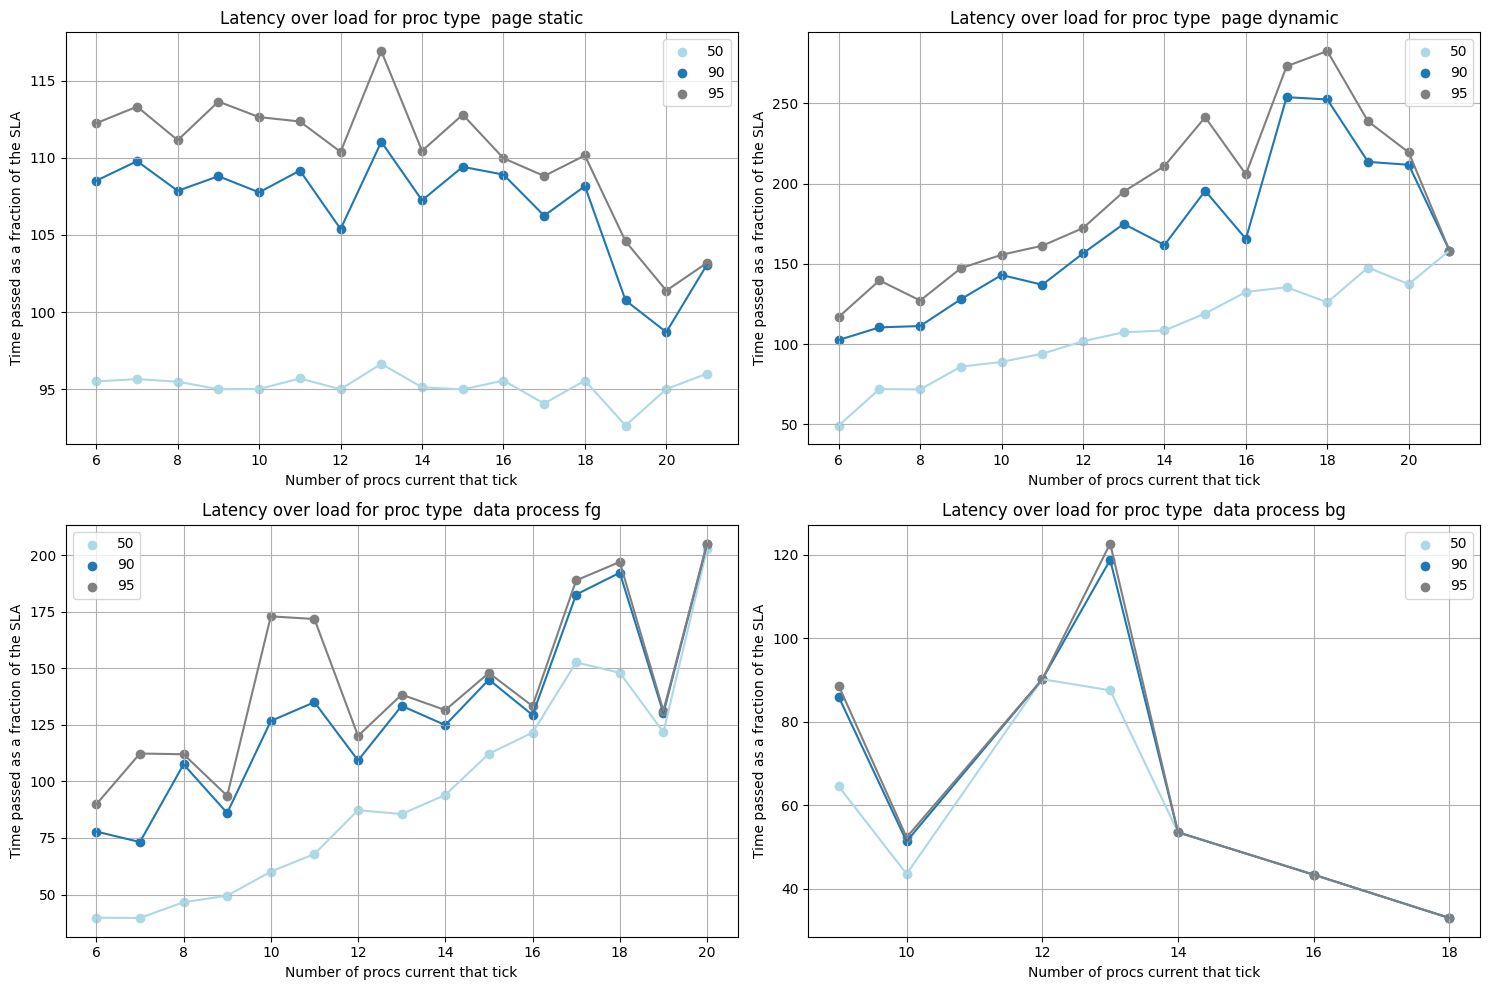

In [535]:
# Proc latency (as a percentage of their SLA) over the load (number of procs currently live)

proc_timings = pd.merge(procs_done, load_num_procs_per_tick, on='tick', how='left')

def get_percentile(pctile, proc_type):
    return proc_timings.where(proc_timings["procType"] == proc_type)[["numProcsCurrent", "timePassedAsPct"]].groupby("numProcsCurrent").quantile(pctile / 100).reset_index()

plt.figure(figsize=(15,6))

unique_ids = proc_timings['procType'].unique()

# Set up subplots
num_plots = len(unique_ids)
num_cols = 2  # Adjust as needed
num_rows = -(-num_plots // num_cols)  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
if num_rows > 1 and num_cols > 1:
    axes = axes.flatten()

# Plot each machine's data
for i, id_ in enumerate(unique_ids):
    ax = axes[i]
    ax.scatter(get_percentile(50, id_)["numProcsCurrent"], get_percentile(50, id_)["timePassedAsPct"], color='lightblue', label="50")
    ax.plot(get_percentile(50, id_)["numProcsCurrent"], get_percentile(50, id_)["timePassedAsPct"], color='lightblue')

    ax.scatter(get_percentile(90, id_)["numProcsCurrent"], get_percentile(90, id_)["timePassedAsPct"], label="90")
    ax.plot(get_percentile(90, id_)["numProcsCurrent"], get_percentile(90, id_)["timePassedAsPct"])

    ax.scatter(get_percentile(95, id_)["numProcsCurrent"], get_percentile(95, id_)["timePassedAsPct"], color='grey', label="95")
    ax.plot(get_percentile(95, id_)["numProcsCurrent"], get_percentile(95, id_)["timePassedAsPct"], color='grey')

    ax.set_title(f'Latency over load for proc type {id_}')
    ax.set_xlabel('Number of procs current that tick')
    ax.set_ylabel('Time passed as a fraction of the SLA')
    ax.legend()
    ax.grid(True)

# If there are unused subplots, hide them
for i in range(len(unique_ids), num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()



In [540]:
late = proc_timings.where((proc_timings["timePassedAsPct"] > 100)).dropna()
typed = late.where(late["procType"].str.contains("fg")).dropna()
unreplenished = typed.where(typed["timesReplenished"] == 0).dropna()

unreplenished.sort_values("timePassedAsPct", ascending=False)

,tick,machineID,procType,sla,ticksPassed,actualComp,timesReplenished,timePassedAsPct,numProcsCurrent
4088,682.0,1.0,data process fg,4.577940,13.425082,4.171327,0.0,293.255937,8.0
2623,438.0,1.0,data process fg,4.618273,9.610584,4.422903,0.0,208.099084,11.0
2566,430.0,1.0,data process fg,3.063589,6.208847,2.589922,0.0,202.665776,20.0
1438,242.0,0.0,data process fg,3.030367,5.915338,3.018877,0.0,195.202029,17.0
2180,364.0,1.0,data process fg,3.122773,5.858000,2.977270,0.0,187.589722,10.0
2621,438.0,1.0,data process fg,4.904361,8.112330,3.871923,0.0,165.410540,11.0
4055,678.0,0.0,data process fg,4.090493,6.698254,3.789588,0.0,163.751741,17.0
5413,904.0,1.0,data process fg,4.990523,7.617479,4.793645,0.0,152.638905,17.0
2688,450.0,1.0,data process fg,3.651773,5.511713,3.564133,0.0,150.932513,15.0
1467,246.0,0.0,data process fg,4.016708,5.948173,3.403425,0.0,148.085766,13.0


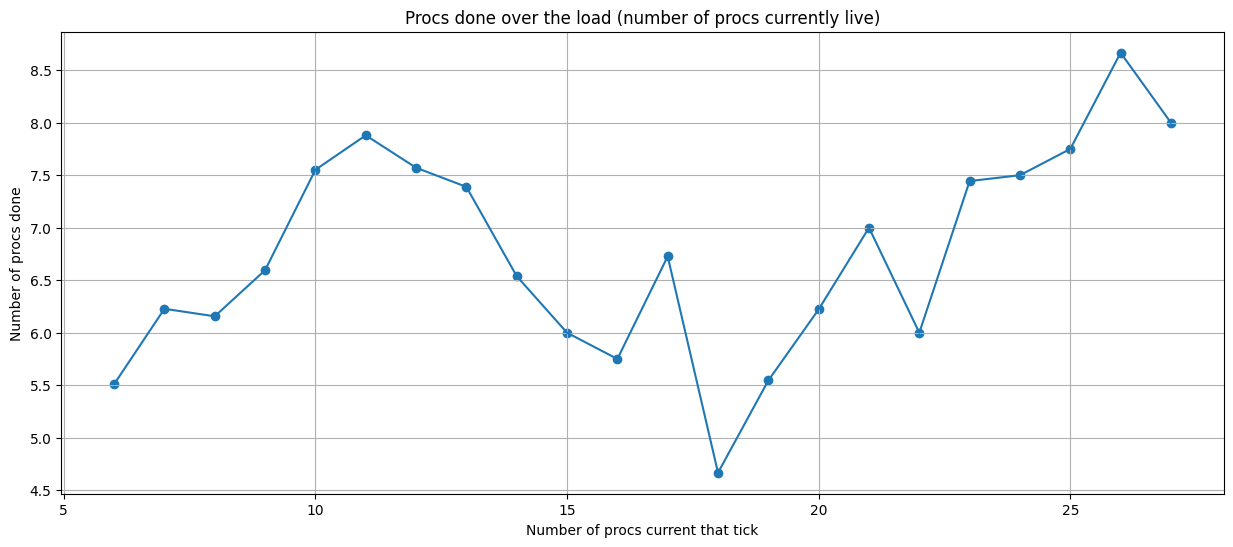

In [37]:
# Procs done over the load (number of procs currently live)
 
num_done = procs_done[["tick"]].groupby("tick").size().reset_index(name='numProcsDone')

merged_done_added = pd.merge(num_done, load_num_procs_per_tick, on='tick', how='left')

avg_done = merged_done_added[["numProcsCurrent", "numProcsDone"]].groupby("numProcsCurrent").mean().reset_index()

plt.figure(figsize=(15,6))
plt.scatter(avg_done["numProcsCurrent"], avg_done["numProcsDone"])
plt.plot(avg_done["numProcsCurrent"], avg_done["numProcsDone"])

plt.title('Procs done over the load (number of procs currently live)')
plt.xlabel('Number of procs current that tick')
plt.ylabel('Number of procs done')
plt.grid(True)
plt.show()

--------------------------------

# Procs late overview

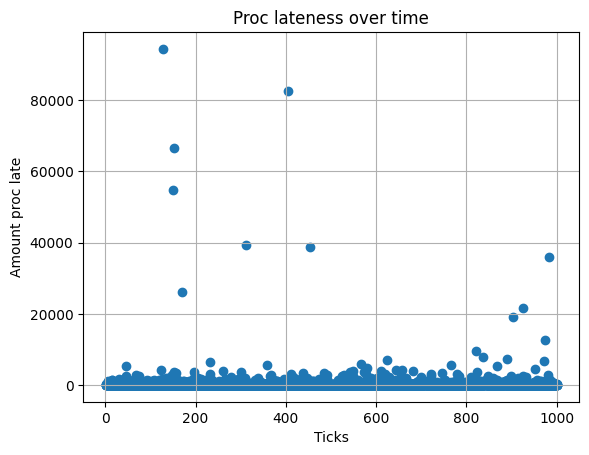

In [125]:
# plot by tick
plt.scatter(procs_late["tick"], procs_late['timePassedAsPct'].values)
plt.xlabel('Ticks')
plt.ylabel('Amount proc late')
plt.title('Proc lateness over time')
plt.grid(True)
plt.show()

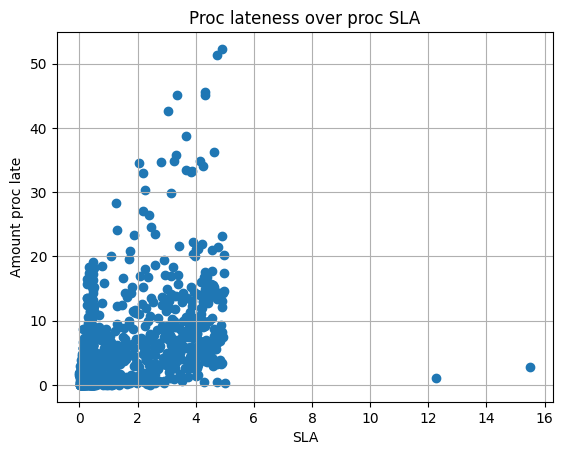

In [97]:
# plot by SLA
plt.scatter(procs_late["sla"], procs_late['amountLate'].values)
plt.xlabel('SLA')
plt.ylabel('Amount proc late')
plt.title('Proc lateness over proc SLA')
plt.grid(True)
plt.show()

# Procs killed overview

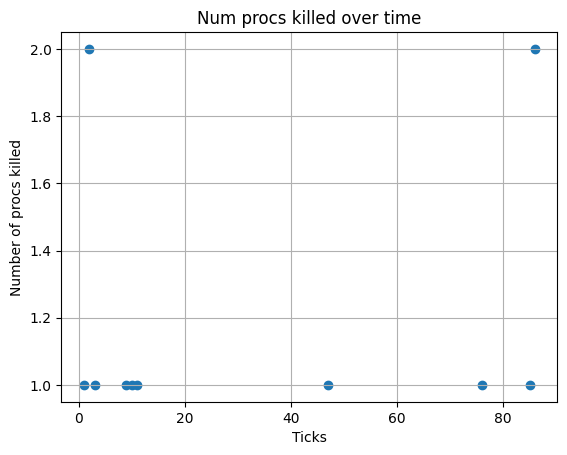

In [98]:
# plot by tick
ticks_procs_killed = procs_killed[["tick"]].groupby("tick").size().reset_index(name='counts')
ticks_procs_killed

plt.scatter(ticks_procs_killed["tick"], ticks_procs_killed['counts'].values)
plt.xlabel('Ticks')
plt.ylabel('Number of procs killed')
plt.title('Num procs killed over time')
plt.grid(True)
plt.show()

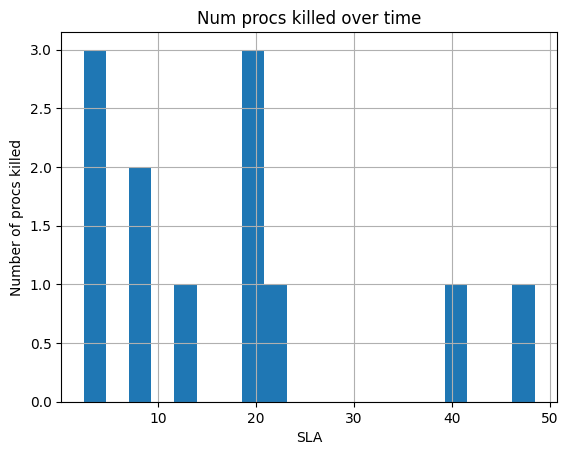

In [102]:
# plot by SLA
plt.hist(procs_killed["sla"], bins=20)
plt.xlabel('SLA')
plt.ylabel('Number of procs killed')
plt.title('Num procs killed over time')
plt.grid(True)
plt.show()

# Utilization Overview

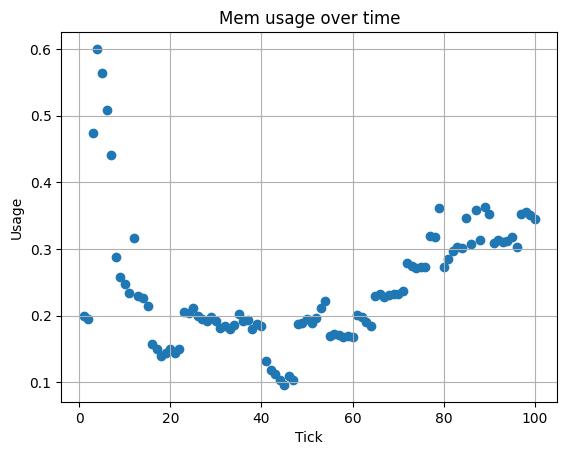

In [121]:
# plot memory usage over time
grouped = active_machines_usage.groupby('tick')["memUsage"].mean().reset_index()
# grouped["tick"]
plt.scatter(grouped["tick"], grouped["memUsage"])
plt.xlabel('Tick')
plt.ylabel('Memory Usage')
plt.title('Mem usage over time')
plt.grid(True)
plt.show()

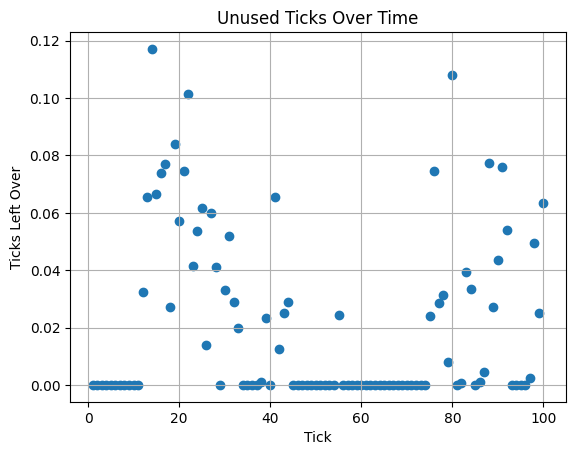

In [123]:
# plot ticks left over, over time
grouped = active_machines_usage.groupby('tick')["unusedTicks"].mean().reset_index()
# grouped["tick"]
plt.scatter(grouped["tick"], grouped["unusedTicks"])
plt.xlabel('Tick')
plt.ylabel('Ticks Left Over')
plt.title('Unused Ticks Over Time')
plt.grid(True)
plt.show()